To train a GAN on Piano audio

## Setup

This code uses the [`pretty_midi`](https://github.com/craffel/pretty-midi) library to create and parse MIDI files, and [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) for generating audio playback.   

In [1]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 32.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for mido>=1.1.16 from https://files.pythonhosted.org/packages/b0/0e/b551e09391220208764c00ed2b382e198414329d8b6037eeb54a8008d737/mido-1.3.0-py3-none-any.whl.metadata
  Obtaining dependency information for packaging~=23.1 from https://files.pythonhosted.org/packages/ec/1a/610693ac4ee14fcdf2d9bf3c493370e4f2ef7ae2e19217d7a237ff42367d/packaging-23.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.7 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=2fe6f03c847709737f5b830b8c6071b4d74d53f995584151e601466158805ef9
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  At

In [2]:
!pip install --upgrade pretty_midi

In [3]:
import collections
import datetime
# import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Download the Maestro dataset

In [5]:
data_dir = pathlib.Path('/kaggle/input/maestropianomidi/maestro-v3.0.0')

The dataset contains about 1,200 MIDI files.

In [6]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1276


## Process a MIDI file

First, use ```pretty_midi``` to parse a single MIDI file and inspect the format of the notes. If you would like to download the MIDI file below to play on your computer, you can do so in colab by writing ```files.download(sample_file)```.


In [7]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

In [8]:
sample_file = filenames[2]
print(sample_file)

/kaggle/input/maestropianomidi/maestro-v3.0.0/2017/MIDI-Unprocessed_045_PIANO045_MID--AUDIO-split_07-06-17_Piano-e_2-01_wav--2.midi


Generate a `PrettyMIDI` object for the sample MIDI file.

In [9]:
pm = pretty_midi.PrettyMIDI(sample_file)

Play the sample file. The playback widget may take several seconds to load.

In [10]:
import IPython.display as display

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=20, sampling_rate=44100):
    # Synthesize the MIDI data into an audio waveform
    audio_data = pm.synthesize(fs=sampling_rate)

    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = audio_data[:int(seconds * sampling_rate)]

    # Display the audio
    return display.Audio(waveform_short, rate=sampling_rate)

In [11]:
display_audio(pm)

Do some inspection on the MIDI file. What kinds of instruments are used?

In [12]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)
print(len(instrument.notes))
print(instrument.notes[:5])

Number of instruments: 1
Instrument name: Acoustic Grand Piano
6189
[Note(start=1.029167, end=1.447917, pitch=60, velocity=40), Note(start=1.046875, end=1.478125, pitch=36, velocity=33), Note(start=1.476042, end=1.592708, pitch=32, velocity=29), Note(start=1.461458, end=1.604167, pitch=56, velocity=36), Note(start=1.579167, end=3.172917, pitch=29, velocity=29)]


## Extract notes

In [13]:
for i, note in enumerate(instrument.notes[:10]):
  print(i, note)
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0 Note(start=1.029167, end=1.447917, pitch=60, velocity=40)
0: pitch=60, note_name=C4, duration=0.4188
1 Note(start=1.046875, end=1.478125, pitch=36, velocity=33)
1: pitch=36, note_name=C2, duration=0.4312
2 Note(start=1.476042, end=1.592708, pitch=32, velocity=29)
2: pitch=32, note_name=G#1, duration=0.1167
3 Note(start=1.461458, end=1.604167, pitch=56, velocity=36)
3: pitch=56, note_name=G#3, duration=0.1427
4 Note(start=1.579167, end=3.172917, pitch=29, velocity=29)
4: pitch=29, note_name=F1, duration=1.5938
5 Note(start=1.602083, end=3.184375, pitch=53, velocity=36)
5: pitch=53, note_name=F3, duration=1.5823
6 Note(start=3.104167, end=3.428125, pitch=56, velocity=45)
6: pitch=56, note_name=G#3, duration=0.3240
7 Note(start=3.089583, end=3.465625, pitch=32, velocity=42)
7: pitch=32, note_name=G#1, duration=0.3760
8 Note(start=3.455208, end=3.530208, pitch=36, velocity=41)
8: pitch=36, note_name=C2, duration=0.0750
9 Note(start=3.459375, end=3.554167, pitch=60, velocity=45)
9: pitch=

We will use three variables to represent a note when training the model: `pitch`, `step` and `duration`. The pitch is the perceptual quality of the sound as a MIDI note number. 
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times. 


Extract the notes from the sample MIDI file.

In [14]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [15]:
raw_notes = midi_to_notes(sample_file)
raw_notes

pitch       start         end      step  duration
0        60    1.029167    1.447917  0.000000  0.418750
1        36    1.046875    1.478125  0.017708  0.431250
2        56    1.461458    1.604167  0.414583  0.142708
3        32    1.476042    1.592708  0.014583  0.116667
4        29    1.579167    3.172917  0.103125  1.593750
...     ...         ...         ...       ...       ...
6184     72  513.872917  514.040625  0.218750  0.167708
6185     68  514.108333  514.166667  0.235417  0.058333
6186     72  514.760417  515.430208  0.652083  0.669792
6187     29  514.761458  515.423958  0.001042  0.662500
6188     68  514.797917  515.395833  0.036458  0.597917

[6189 rows x 5 columns]

It is easier to interpret the note names rather than the pitches, so we use the function below to convert from the numeric pitch values to note names. 
The note name shows the type of note, accidental and octave number
(e.g. C#4). 

In [16]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names

array(['C4', 'C2', 'G#3', ..., 'C5', 'F1', 'G#4'], dtype='<U3')

To visualize the musical piece, plot the note pitch, start and end across the length of the track (i.e. piano roll). We start with the first 100 notes

In [17]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

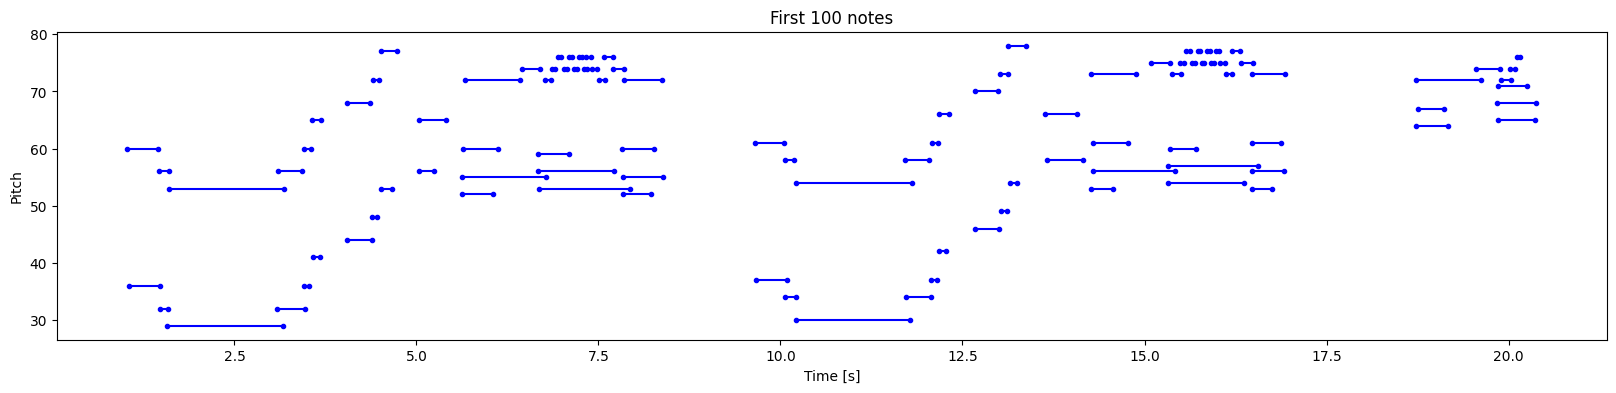

In [18]:
plot_piano_roll(raw_notes, count=100)

Plot the notes for the entire track.

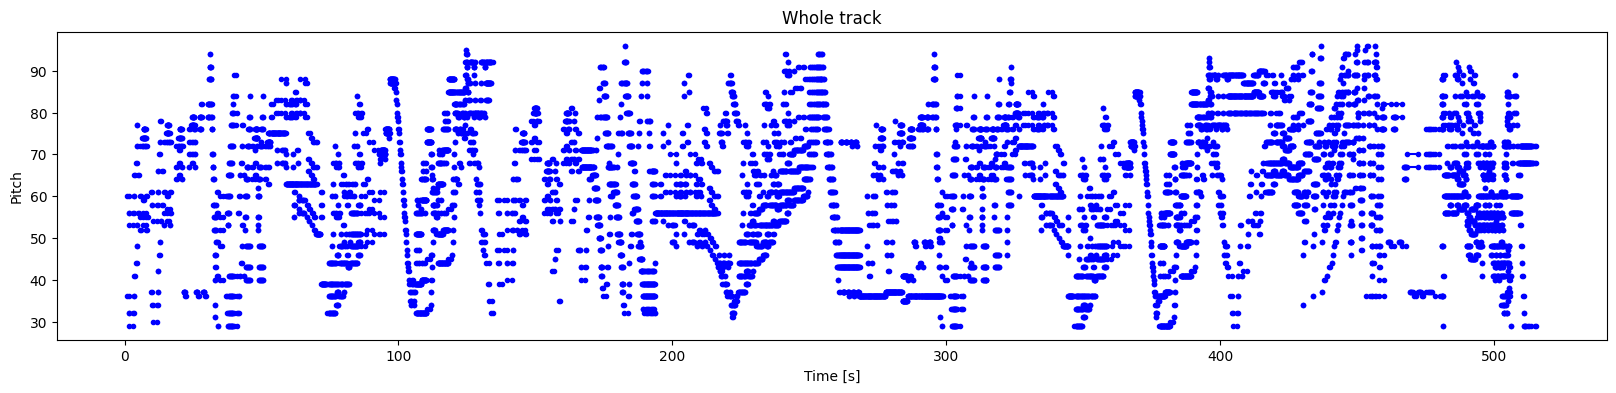

In [19]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable.

In [20]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

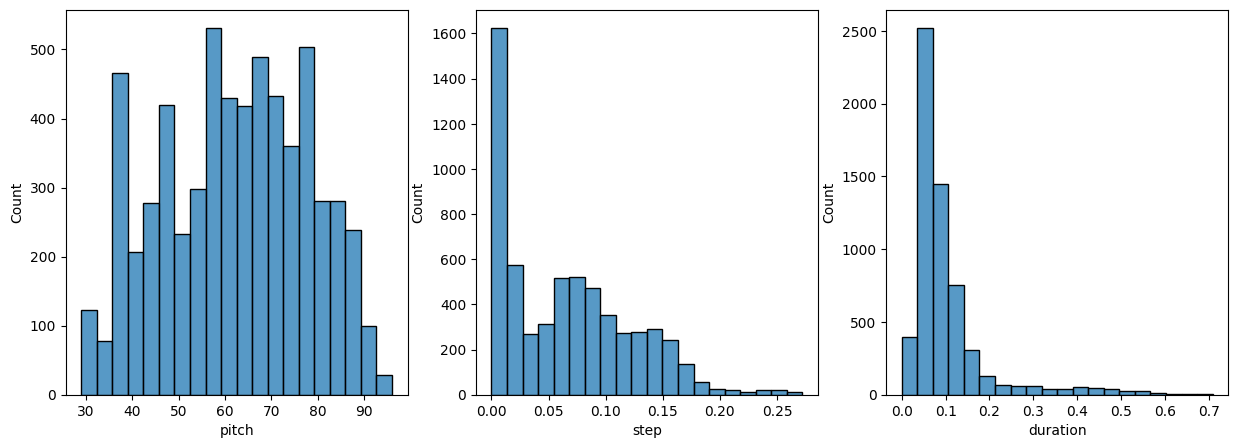

In [21]:
plot_distributions(raw_notes)

## Create a MIDI file

We can generate a MIDI file from a list of notes using the function below.

In [22]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [23]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Play the generated MIDI file and see if there is any difference.

In [24]:
display_audio(example_pm)

```files.download(example_file)``` to download and play this file.

## Create the training dataset


Create the training dataset by extracting notes from the MIDI files. We start by using a small number of files, and experiment later with more. This may take a couple minutes.

In [25]:
num_files = 6
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [26]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 22617


Next, create a `tf.data.Dataset` from the parsed notes.

In [27]:
key_order = ['pitch', 'step', 'duration']

# Create separate arrays for pitch, step, and duration
train_pitch = all_notes[key_order[0]]
train_step = all_notes[key_order[1]]
train_duration = all_notes[key_order[2]]

print("Pitch array:", train_pitch[:5])
print("Step array:", train_step[:5])
print("Duration array:", train_duration[:5])

print("Length of arrays:", len(train_pitch))


Pitch array: 0    45
1    72
2    74
3    76
4    77
Name: pitch, dtype: int64
Step array: 0    0.000000
1    0.131250
2    0.098958
3    0.093750
4    0.096875
Name: step, dtype: float64
Duration array: 0    0.902083
1    0.121875
2    0.112500
3    0.115625
4    0.748958
Name: duration, dtype: float64
Length of arrays: 22617


In [28]:
pitch_ds = tf.data.Dataset.from_tensor_slices(train_pitch)
step_ds = tf.data.Dataset.from_tensor_slices(train_step)
duration_ds = tf.data.Dataset.from_tensor_slices(train_duration)
pitch_ds.element_spec
step_ds.element_spec
duration_ds.element_spec

TensorSpec(shape=(), dtype=tf.float64, name=None)

In [29]:
# import torch
# from torch.utils.data import Dataset, DataLoader

# class MIDISequenceDataset(Dataset):
#     def __init__(self, notes_df, sequence_length=5):
#         self.notes_df = notes_df
#         self.sequence_length = sequence_length

#     def __len__(self):
#         return len(self.notes_df)

#     def __getitem__(self, idx):
#         current_note = self.notes_df.iloc[idx]
        
#         # Extract current note features
#         pitch = torch.FloatTensor(current_note['pitch'])
#         start = torch.FloatTensor(current_note['start'])
#         end = torch.FloatTensor(current_note['end'])
#         step = torch.FloatTensor(current_note['step'])
#         duration = torch.FloatTensor(current_note['duration'])

#         # Get previous notes as context
#         context_start_idx = max(0, idx - self.sequence_length)
#         context_notes = self.notes_df.iloc[context_start_idx:idx]

#         # Pad with zeros if the context is shorter than sequence_length
#         if len(context_notes) < self.sequence_length:
#             pad_length = self.sequence_length - len(context_notes)
#             padding = torch.zeros((pad_length, len(self.notes_df.columns)))
#             context_notes = torch.cat([padding, context_notes])

#         # You can add other features or labels as needed
#         return {
#             'pitch': pitch,
#             'start': start,
#             'end': end,
#             'step': step,
#             'duration': duration,
#             'context': context_notes
#         }

# # Create the dataset with a sequence length of 5
# data_set = MIDISequenceDataset(train_notes, sequence_length=5)
# print(data_set)

In [30]:
# def create_noise_sequences(batch_size: int, seq_length: int, latent_dim: int) -> tf.data.Dataset:
#     """Returns TF Dataset of sequences of random noise for the generator."""
#     noise = tf.random.normal([batch_size, seq_length, latent_dim])
#     return tf.data.Dataset.from_tensor_slices(noise)

# # Example usage:
# batch_size = 64
# latent_dim = 100
# seq_length = 16
# noise_ds = create_noise_sequences(batch_size, seq_length, latent_dim)

# for noise_sequence in noise_ds.take(1):
#     print('Noise sequence shape:', noise_sequence.shape)
#     print('Noise sequence elements (first 10):', noise_sequence)

In [31]:
# def create_sequences(
#     dataset: tf.data.Dataset,
#     seq_length: int,
#     vocab_size,  # possible pitch values = 128
# ) -> tf.data.Dataset:
#     """Returns TF Dataset of sequence and label examples for the discriminator."""
#     seq_length = seq_length + 1

#     # Take 1 extra for the labels
#     windows = dataset.window(seq_length, shift=1, stride=1,
#                               drop_remainder=True)

#     # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
#     flatten = lambda x: x.batch(seq_length, drop_remainder=True)
#     sequences = windows.flat_map(flatten)

#     # Normalize note pitch
#     def scale_(x):
#         x = x / [vocab_size, 1.0, 1.0]
#         return x

#     # Split the labels
#     def split_labels(sequences):
#         inputs = sequences[:-1]
#         labels_dense = sequences[-1]
#         labels = {key: labels_dense[i] for i, key in enumerate(key_order)}

#         return scale_pitch(inputs), labels

#     return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [32]:
def create_pitch_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size=128,  # possible pitch values = 128
) -> tf.data.Dataset:
    """Returns TF Dataset of pitch sequences and label examples."""
    seq_length = seq_length + 1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

    # `flat_map` flattens the dataset of datasets into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    pitch_sequences = windows.flat_map(flatten)

    # Normalize pitch
    def scale_pitch(x):
        return x / vocab_size

    # Split the labels
    def split_pitch_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        return scale_pitch(inputs), scale_pitch(labels_dense)

    return pitch_sequences.map(split_pitch_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [33]:
def create_step_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
) -> tf.data.Dataset:
    """Returns TF Dataset of step sequences and label examples."""
    seq_length = seq_length + 1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

    # `flat_map` flattens the dataset of datasets into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    step_sequences = windows.flat_map(flatten)

    # No need for normalization in this case
    # Split the labels
    def split_step_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        return inputs, labels_dense

    return step_sequences.map(split_step_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [34]:
def create_duration_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
) -> tf.data.Dataset:
    """Returns TF Dataset of duration sequences and label examples."""
    seq_length = seq_length + 1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

    # `flat_map` flattens the dataset of datasets into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    duration_sequences = windows.flat_map(flatten)

    # No need for normalization in this case
    # Split the labels
    def split_duration_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        return inputs, labels_dense

    return duration_sequences.map(split_duration_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experimenting with various values, we find that the sequence length of 256 gives the best results. The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [35]:
seq_length = 256
vocab_size_pitch = 128
seq1_ds = create_pitch_sequences(pitch_ds, seq_length, vocab_size_pitch)
seq2_ds = create_step_sequences(step_ds, seq_length)
seq3_ds = create_duration_sequences(duration_ds, seq_length)
print(seq1_ds.element_spec)
print(seq2_ds.element_spec)
print(seq3_ds.element_spec)

(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))
(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))
(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))


The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [36]:
for seq, target in seq1_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements:', seq)
  print()
  print('target:', target)

for seq, target in seq2_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements:', seq)
  print()
  print('target:', target)
    
for seq, target in seq3_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements:', seq)
  print()
  print('target:', target)

sequence shape: (256,)
sequence elements: tf.Tensor(
[0.3515625 0.5625    0.578125  0.59375   0.6015625 0.4453125 0.5625
 0.4375    0.5546875 0.5859375 0.4296875 0.59375   0.546875  0.5390625
 0.421875  0.5703125 0.578125  0.4140625 0.53125   0.40625   0.5390625
 0.390625  0.5546875 0.5       0.375     0.390625  0.40625   0.5390625
 0.4140625 0.375     0.3671875 0.53125   0.3984375 0.5234375 0.40625
 0.359375  0.3515625 0.515625  0.3828125 0.5078125 0.390625  0.34375
 0.5       0.3515625 0.484375  0.3671875 0.3125    0.46875   0.4609375
 0.3515625 0.46875   0.5390625 0.3671875 0.53125   0.3828125 0.59375
 0.5234375 0.390625  0.5078125 0.5       0.4921875 0.3671875 0.5546875
 0.3828125 0.546875  0.609375  0.3984375 0.5390625 0.40625   0.5234375
 0.5390625 0.5546875 0.5625    0.5       0.5234375 0.4921875 0.515625
 0.546875  0.5546875 0.484375  0.5078125 0.4765625 0.5       0.53125
 0.46875   0.5390625 0.4921875 0.4609375 0.5       0.4453125 0.515625
 0.4609375 0.4296875 0.4453125 0.4609

Batch the examples, and configure the dataset for performance.

In [37]:
batch_size = 256
buffer_size = n_notes - seq_length  # the number of items in the dataset
train1_ds = (seq1_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

train2_ds = (seq2_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

train3_ds = (seq3_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [38]:
print(train1_ds.element_spec)
print(train2_ds.element_spec)
print(train3_ds.element_spec)

(TensorSpec(shape=(256, 256), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None))
(TensorSpec(shape=(256, 256), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None))
(TensorSpec(shape=(256, 256), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None))


## Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [39]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [40]:
# Define custom loss functions for discriminator
def pitch_loss(y_true, y_pred):
    return tf.keras.losses.sparse_categorical_crossentropy(y_true[:, :, 0], y_pred[:, :, 0], from_logits=True)

def step_loss(y_true, y_pred):
    return mse_with_positive_pressure(y_true[:, :, 1], y_pred[:, :, 1])

def duration_loss(y_true, y_pred):
    return mse_with_positive_pressure(y_true[:, :, 2], y_pred[:, :, 2])

In [41]:
# tf.keras.layers.Conv1D(
#     filters,
#     kernel_size,
#     strides=1,
#     padding='valid',
#     data_format='channels_last',
#     dilation_rate=1,
#     groups=1,
#     activation=None,
#     use_bias=True,
#     kernel_initializer='glorot_uniform',
#     bias_initializer='zeros',
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     **kwargs
# )

# tf.keras.layers.Conv1DTranspose(
#     filters,
#     kernel_size,
#     strides=1,
#     padding='valid',
#     output_padding=None,
#     data_format=None,
#     dilation_rate=1,
#     activation=None,
#     use_bias=True,
#     kernel_initializer='glorot_uniform',
#     bias_initializer='zeros',
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     **kwargs
# )


In [42]:
# # Generator
# def GANGenerator(latent_dim, output_shape):
#     model = tf.keras.Sequential()
#     model.add(layers.Dense(256, input_dim=latent_dim, activation='relu'))
#     model.add(layers.Reshape((8, 32)))
#     model.add(layers.Conv1DTranspose(16, kernel_size=5, strides=2, padding='same', activation='relu'))
#     model.add(layers.Conv1DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh'))
#     model.add(layers.Reshape(output_shape))
#     return model

# # Discriminator
# def GANDiscriminator(input_shape):
#     model = tf.keras.Sequential()
#     model.add(layers.Conv1D(16, kernel_size=5, strides=2, padding='same', input_shape=input_shape, activation='relu'))
#     model.add(layers.Conv1D(32, kernel_size=5, strides=2, padding='same', activation='relu'))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(1, activation='sigmoid'))
#     return model

# # GAN
# def build_gan(generator, discriminator):
#     discriminator.trainable = False
#     model = tf.keras.Sequential()
#     model.add(generator)
#     model.add(discriminator)
#     return model

In [43]:
latent_dim = 100
seq_len = 256
input_shape = (seq_length, 3)
dim_mult = 16
dim = 32

In [44]:
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv1D, Conv1DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import BatchNormalization, Conv1D, Dense, Flatten, MaxPooling1D, Reshape
from tensorflow.keras.models import Sequential

def build_generator(latent_dim, seq_len):
    input_layer = Input(shape=(latent_dim,))
    print("Latent Dimension:", latent_dim)

    x = Dense(128, activation='relu')(input_layer)
    print("After Dense(128):", x.shape)

    x = Reshape((128, 1))(x)
    print("After Reshape:", x.shape)

    x = BatchNormalization()(x)
    print("After BatchNormalization:", x.shape)

    x = Conv1DTranspose(64, kernel_size=5, activation='relu', padding='same')(x)
    print("After Conv1DTranspose(64):", x.shape)

    x = BatchNormalization()(x)
    print("After BatchNormalization:", x.shape)

    x = MaxPooling1D(2)(x)
    print("After MaxPooling1D:", x.shape)

    x = Conv1DTranspose(32, kernel_size=5, activation='relu', padding='same')(x)
    print("After Conv1DTranspose(32):", x.shape)

    x = BatchNormalization()(x)
    print("After BatchNormalization:", x.shape)

    x = MaxPooling1D(2)(x)
    print("After MaxPooling1D:", x.shape)

    x = Conv1DTranspose(16, kernel_size=5, activation='relu', padding='same')(x)
    print("After Conv1DTranspose(16):", x.shape)

    x = BatchNormalization()(x)
    print("After BatchNormalization:", x.shape)

    x = MaxPooling1D(2)(x)
    print("After MaxPooling1D:", x.shape)

    x = Conv1DTranspose(4, kernel_size=5, activation='relu', padding='same')(x)
    print("After Conv1DTranspose(4):", x.shape)

    x = BatchNormalization()(x)
    print("After BatchNormalization:", x.shape)

    # Modify the Flatten layer to ensure compatibility with the subsequent Dense layer
    x = Flatten()(x)
    print("After Flatten:", x.shape)

    output_layer = Dense(seq_len, activation='tanh')(x)
    print("After Dense:", output_layer.shape)

    return Model(inputs=input_layer, outputs=output_layer, name='generator')


def build_discriminator(input_dim):
    input_layer = Input(shape=input_dim)
    print("Discriminator Input Dimensions:", input_dim)

    x = Reshape((seq_len, 1))(input_layer)
    print("After Reshape:", x.shape)

    x = BatchNormalization()(x)
    print("After BatchNormalization:", x.shape)

    x = MaxPooling1D(2)(x)
    print("After MaxPooling1D:", x.shape)

    x = Conv1D(16, kernel_size=5, activation='relu', padding='same')(x)
    print("After Conv1D(16):", x.shape)

    x = BatchNormalization()(x)
    print("After BatchNormalization:", x.shape)

    x = MaxPooling1D(2)(x)
    print("After MaxPooling1D:", x.shape)

    x = Conv1D(32, kernel_size=5, activation='relu', padding='same')(x)
    print("After Conv1D(32):", x.shape)

    x = BatchNormalization()(x)
    print("After BatchNormalization:", x.shape)

    x = MaxPooling1D(2)(x)
    print("After MaxPooling1D:", x.shape)

    x = Conv1D(64, kernel_size=5, activation='relu', padding='same')(x)
    print("After Conv1D(64):", x.shape)

    x = BatchNormalization()(x)
    print("After BatchNormalization:", x.shape)

    x = MaxPooling1D(2)(x)
    print("After MaxPooling1D:", x.shape)

    x = Flatten()(x)
    print("After Flatten:", x.shape)

    output_layer = Dense(1, activation='sigmoid')(x)
    print("After Dense:", output_layer.shape)

    model = Model(inputs=input_layer, outputs=output_layer, name='discriminator')
    return model


def build_gan(generator, discriminator):
    discriminator.trainable = True
    input_layer = Input(shape=(latent_dim,))
    generated_sequence = generator(input_layer)
    discriminator_output = discriminator(generated_sequence)
    model = Model(inputs=input_layer, outputs=discriminator_output, name='gan')
    return model


# Specify input dimensions
latent_dim = 256  # Dimension of the random noise vector
sequence_dim = seq_len  # Assuming seq_length, pitch, step, duration

# Build the generator
generator_pitch = build_generator(latent_dim, seq_len)
generator_step = build_generator(latent_dim, seq_len)
generator_duration = build_generator(latent_dim, seq_len)

# Build the discriminator
discriminator_pitch = build_discriminator(seq_len)
discriminator_step = build_discriminator(seq_len)
discriminator_duration = build_discriminator(seq_len)

# Build the GAN model
gan_pitch = build_gan(generator_pitch, discriminator_pitch)
gan_step = build_gan(generator_step, discriminator_step)
gan_duration = build_gan(generator_duration, discriminator_duration)

# Compile the discriminator with custom losses
discriminator_pitch.compile(loss=wasserstein_loss, optimizer=tf.keras.optimizers.RMSprop(lr=0.00005))

discriminator_step.compile(loss=wasserstein_loss, optimizer=tf.keras.optimizers.RMSprop(lr=0.00005))

discriminator_duration.compile(loss=wasserstein_loss, optimizer=tf.keras.optimizers.RMSprop(lr=0.00005))

# Compile the GAN model (use binary crossentropy for a binary classification task)
gan_pitch.compile(loss=wasserstein_loss, optimizer=tf.keras.optimizers.RMSprop(lr=0.00005))
gan_step.compile(loss=wasserstein_loss, optimizer=tf.keras.optimizers.RMSprop(lr=0.00005))
gan_duration.compile(loss=wasserstein_loss, optimizer=tf.keras.optimizers.RMSprop(lr=0.00005))

# Print a summary of the generator, discriminator, and GAN models
generator_pitch.summary()
discriminator_pitch.summary()
gan_pitch.summary()


Latent Dimension: 256
After Dense(128): (None, 128)
After Reshape: (None, 128, 1)
After BatchNormalization: (None, 128, 1)
After Conv1DTranspose(64): (None, 128, 64)
After BatchNormalization: (None, 128, 64)
After MaxPooling1D: (None, 64, 64)
After Conv1DTranspose(32): (None, 64, 32)
After BatchNormalization: (None, 64, 32)
After MaxPooling1D: (None, 32, 32)
After Conv1DTranspose(16): (None, 32, 16)
After BatchNormalization: (None, 32, 16)
After MaxPooling1D: (None, 16, 16)
After Conv1DTranspose(4): (None, 16, 4)
After BatchNormalization: (None, 16, 4)
After Flatten: (None, 64)
After Dense: (None, 256)
Latent Dimension: 256
After Dense(128): (None, 128)
After Reshape: (None, 128, 1)
After BatchNormalization: (None, 128, 1)
After Conv1DTranspose(64): (None, 128, 64)
After BatchNormalization: (None, 128, 64)
After MaxPooling1D: (None, 64, 64)
After Conv1DTranspose(32): (None, 64, 32)
After BatchNormalization: (None, 64, 32)
After MaxPooling1D: (None, 32, 32)
After Conv1DTranspose(16): (N

In [46]:
# # Number of iterations
# epochs = 50
# batch_size = 32

# def train_wasserstein_gan(generator, discriminator, gan, epochs, batch_size, latent_dim, seq_len, dataset):
#     # Wasserstein loss parameters
#     n_critic = 5
#     clip_value = 0.01

#     for epoch in range(epochs):
#         for _ in range(n_critic):
#             # Train discriminator
#             real_samples = generate_real_samples(dataset, batch_size)
#             noise = generate_latent_points(latent_dim, batch_size)
#             fake_samples = generator.predict(noise)
#             d_loss_real = discriminator.train_on_batch(real_samples, -np.ones((batch_size, 1)))
#             d_loss_fake = discriminator.train_on_batch(fake_samples, np.ones((batch_size, 1)))
#             d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

#             # Clip weights to enforce Lipschitz continuity
#             for layer in discriminator.layers:
#                 weights = layer.get_weights()
#                 weights = [np.clip(w, -clip_value, clip_value) for w in weights]
#                 layer.set_weights(weights)

#         # Train generator
#         noise = generate_latent_points(latent_dim, batch_size)
#         g_loss = gan.train_on_batch(noise, -np.ones((batch_size, 1)))

#         # Print progress and evaluate the model
#         if epoch % 1 == 0:
#             print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

#         # Save and play audio every 100 epochs
#         if epoch % 5 == 0:
#             noise_for_audio = generate_latent_points(latent_dim, 1)
#             generated_sequence = generator.predict(noise_for_audio)
#             generated_notes = pd.DataFrame(data={'pitch': generated_sequence[0], 'step': np.arange(seq_len), 'duration': 1})
#             pm = notes_to_midi(generated_notes, f"generated_audio_epoch_{epoch}.midi", instrument_name="Acoustic Grand Piano")
#             display_audio(pm)

# # Training the Wasserstein GAN
# train_wasserstein_gan(generator_pitch, discriminator_pitch, gan_pitch, epochs, batch_size, latent_dim, seq_len, train1_ds)


In [47]:
'''
from tensorflow.keras import layers, Model, optimizers

# Optimizers
optimizer_generator = optimizers.Adam()
optimizer_discriminator = optimizers.Adam()

# Training loop
num_epochs = 50
batch_size = 32

for epoch in range(num_epochs):
    for n, real_samples in enumerate(train1_ds):
        # Data for training the discriminator
        real_samples_labels = tf.ones((batch_size, 1), dtype=tf.float32)
        latent_space_samples = tf.random.normal((batch_size, latent_dim))
        generated_samples = generator_pitch(latent_space_samples, training=True)
        generated_samples_labels = tf.zeros((batch_size, 1), dtype=tf.float32)

        # Concatenate along the second axis
        all_samples = tf.concat([real_data, generated_samples], axis=0)
        all_samples_labels = tf.concat([real_samples_labels, generated_samples_labels], axis=0)

        # Training the discriminator
        with tf.GradientTape() as tape_discriminator:
            output_discriminator = discriminator_pitch(all_samples, training=True)
            loss_discriminator = wasserstein_loss(output_discriminator, all_samples_labels)

        gradients_discriminator = tape_discriminator.gradient(loss_discriminator, discriminator_pitch.trainable_variables)
        optimizer_discriminator.apply_gradients(zip(gradients_discriminator, discriminator_pitch.trainable_variables))

        # Data for training the generator
        latent_space_samples = tf.random.normal((batch_size, latent_dim))

        # Training the generator
        with tf.GradientTape() as tape_generator:
            generated_samples = generator_pitch(latent_space_samples, training=True)
            output_discriminator_generated = discriminator_pitch(generated_samples, training=True)
            loss_generator = wasserstein_loss(output_discriminator_generated, real_samples_labels)

        gradients_generator = tape_generator.gradient(loss_generator, generator_pitch.trainable_variables)
        optimizer_generator.apply_gradients(zip(gradients_generator, generator_pitch.trainable_variables))

        # Show loss
        if epoch % 1== 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
        
        if epoch % 1 == 0:
            num_generated_samples = 100  # Adjust as needed
            latent_space_samples = tf.random.normal((num_generated_samples, latent_dim))
            generated_pitch = generator_pitch(latent_space_samples, training=False)

            # Assuming `generated_pitch` is a NumPy array
            np.save(f'generated_pitch_epoch_{epoch}.npy', generated_pitch.numpy())
        '''

'\nfrom tensorflow.keras import layers, Model, optimizers\n\n# Optimizers\noptimizer_generator = optimizers.Adam()\noptimizer_discriminator = optimizers.Adam()\n\n# Training loop\nnum_epochs = 50\nbatch_size = 32\n\nfor epoch in range(num_epochs):\n    for n, real_samples in enumerate(train1_ds):\n        # Data for training the discriminator\n        real_samples_labels = tf.ones((batch_size, 1), dtype=tf.float32)\n        latent_space_samples = tf.random.normal((batch_size, latent_dim))\n        generated_samples = generator_pitch(latent_space_samples, training=True)\n        generated_samples_labels = tf.zeros((batch_size, 1), dtype=tf.float32)\n\n        # Concatenate along the second axis\n        all_samples = tf.concat([real_data, generated_samples], axis=0)\n        all_samples_labels = tf.concat([real_samples_labels, generated_samples_labels], axis=0)\n\n        # Training the discriminator\n        with tf.GradientTape() as tape_discriminator:\n            output_discriminato

In [48]:
import numpy as np
import os
generator=generator_pitch
discriminator=discriminator_pitch
# Function to generate fake data for training the discriminator
def generate_fake_data(generator, batch_size, latent_dim):
    noise = np.random.randn(batch_size, latent_dim)
    return generator.predict(noise)

# Number of training steps
epochs = 100
batch_size = 256
latent_dim = 256  # Assuming your latent dimension size

# Output directory for saving generated samples
output_dir = 'generated_samples'
os.makedirs(output_dir, exist_ok=True)

# Training loop
for epoch in range(epochs):
    # Train the discriminator
    batch_sequences, batch_labels = next(iter(train1_ds))  # Load real data from your dataset
    real_data = batch_sequences  # Use only the input sequences for the discriminator
    fake_data = generate_fake_data(generator, batch_size, latent_dim)

#     print("Real Data", real_data)
#     print("Fake Data", fake_data)
    # Labels for real and fake data
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train discriminator on real data
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)

    # Train discriminator on fake data
    d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)

    # Calculate total discriminator loss
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    noise = np.random.randn(batch_size, latent_dim)
    valid_labels = np.ones((batch_size, 1))

    # Train the generator (via the GAN model)
    g_loss = gan_pitch.train_on_batch(noise, valid_labels)

    # Print progress
    if epoch % 2 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss}, G Loss: {g_loss}")

    # Optionally, you can save generated samples and display audio at certain intervals
    if epoch % 5 == 0:
        # Generate a batch of samples for visualization
        generated_samples = generator.predict(np.random.randn(batch_size, latent_dim))
        for i, sample in enumerate(generated_samples):
            # Convert the generated samples to a DataFrame with columns 'pitch', 'step', 'duration'
            sample_df = pd.DataFrame(sample, columns=['pitch'])
            #'step', 'duration'
            
            # Save generated samples as MIDI files
            #midi_file = os.path.join(output_dir, f'generated_sample_epoch_{epoch}_sample_{i}.midi')
            #notes_to_midi(sample_df, midi_file, instrument_name='Acoustic Grand Piano')
            #print(sample_df)
        # Display the audio of the last generated sample
        #sample_midi = pretty_midi.PrettyMIDI(os.path.join(output_dir, f'generated_sample_epoch_{epoch}_sample_{i}.midi'))
        #display_audio(sample_midi)
print(sample_df)

8/8 [==============================] - 6s 3ms/step
Epoch 0, D Loss: 0.28238359093666077, G Loss: 0.26072391867637634
8/8 [==============================] - 0s 2ms/step
Epoch 2, D Loss: 0.028352530673146248, G Loss: 0.01017596386373043
8/8 [==============================] - 0s 2ms/step
Epoch 4, D Loss: 0.010525193996727467, G Loss: 0.0037341322749853134
8/8 [==============================] - 0s 2ms/step
Epoch 6, D Loss: 0.004497007466852665, G Loss: 0.002768488135188818
8/8 [==============================] - 0s 2ms/step
Epoch 8, D Loss: 0.003491113195195794, G Loss: 0.0013406036887317896
8/8 [==============================] - 0s 2ms/step
Epoch 10, D Loss: 0.002818326698616147, G Loss: 0.0009050067747011781
8/8 [==============================] - 0s 2ms/step
Epoch 12, D Loss: 0.0021575111895799637, G Loss: 0.000996613991446793
8/8 [==============================] - 0s 2ms/step
Epoch 14, D Loss: 0.0015252490993589163, G Loss: 0.0006368823815137148
8/8 [==============================] - 0s 

In [58]:
sample_df.shape

(256, 1)

In [51]:
# from keras.models import load_model

# # Load the model with custom objects
# generator = load_model("/kaggle/input/aaaaaaa/generator_model.h5")


In [59]:
generated_samples = generator.predict(np.random.randn(256, 256))
sample_df2 = pd.DataFrame(generated_samples[200], columns=['pitch'])*128
for i in range(len(sample_df2)):
    if(sample_df2.iloc[i]['pitch']<0):
        sample_df2.iloc[i]['pitch']=0
    
       

start=pd.DataFrame(np.linspace(0,25.6,256))
end=pd.DataFrame(np.linspace(0.1,25.7,256))
duration=pd.DataFrame(np.full(256,0.3))
step=pd.DataFrame(np.full(256,0.025))
    
result = pd.concat([sample_df2,start,end,step,duration], axis=1, ignore_index=True)
result = result.rename(columns={0:'pitch',1: 'start', 2:'end',3:'step',4:'duration'})
result

8/8 [==============================] - 0s 2ms/step


pitch      start        end   step  duration
0    61.625092   0.000000   0.100000  0.025       0.3
1    37.863586   0.100392   0.200392  0.025       0.3
2     0.000000   0.200784   0.300784  0.025       0.3
3     0.000000   0.301176   0.401176  0.025       0.3
4     0.000000   0.401569   0.501569  0.025       0.3
..         ...        ...        ...    ...       ...
251  11.125794  25.198431  25.298431  0.025       0.3
252  27.527229  25.298824  25.398824  0.025       0.3
253   0.000000  25.399216  25.499216  0.025       0.3
254   0.000000  25.499608  25.599608  0.025       0.3
255   0.000000  25.600000  25.700000  0.025       0.3

[256 rows x 5 columns]

In [60]:
import os
output_dir = 'generated_samples'
os.makedirs(output_dir, exist_ok=True)
midi_file2 = os.path.join(output_dir, "test")
notes_to_midi(result, midi_file2, instrument_name='Acoustic Grand Piano')
pm = pretty_midi.PrettyMIDI(midi_file2)

display_audio(pm,seconds=100)

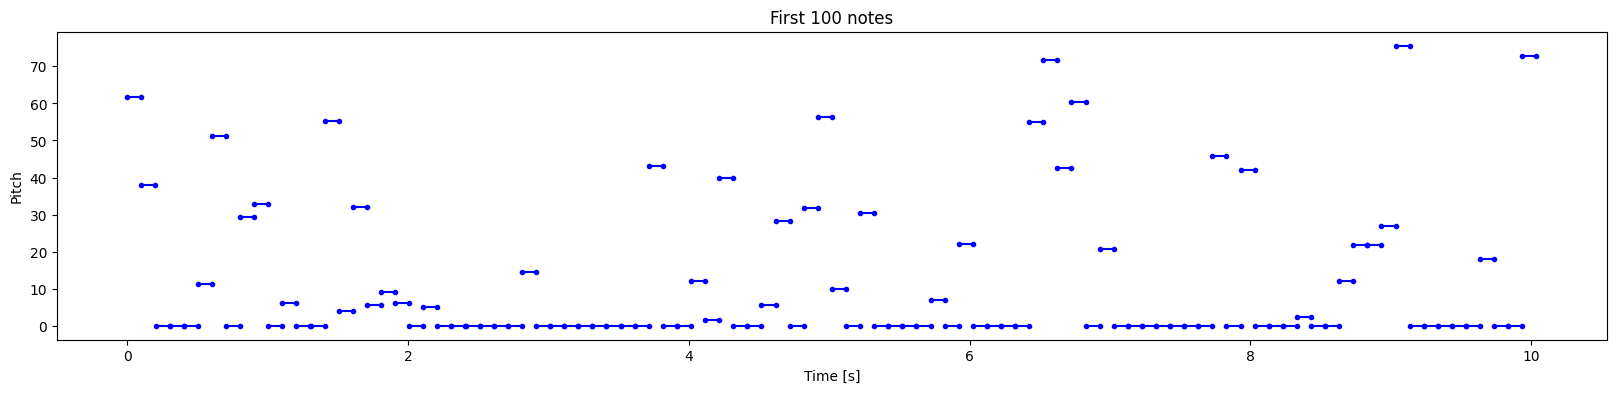

In [61]:
plot_piano_roll(result,count =100)

#notes taken with constant duration and step 

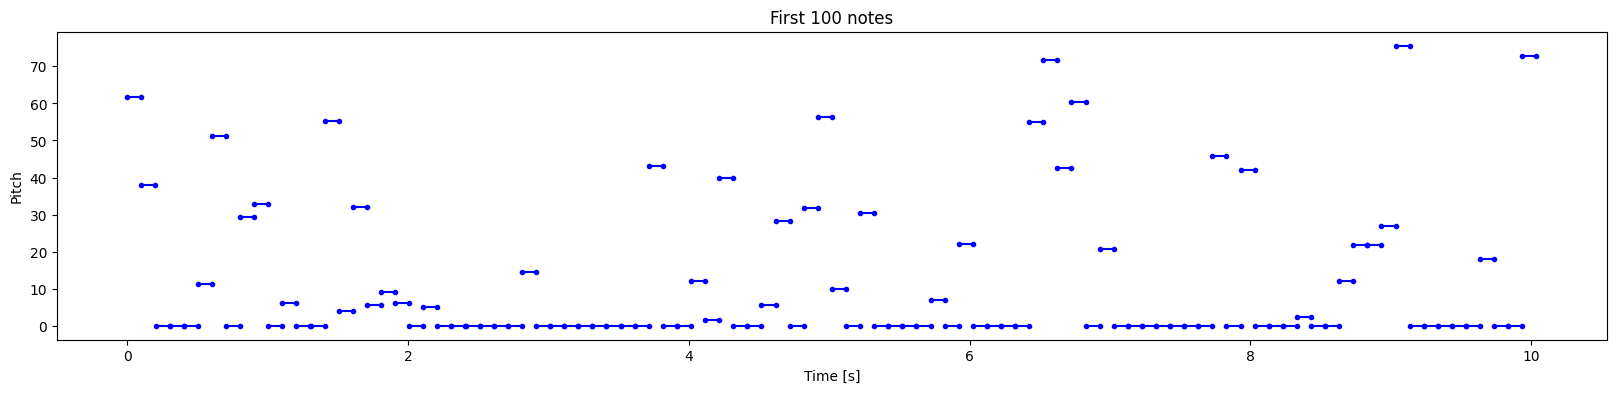

In [62]:
plot_piano_roll(result, count=100)

In [63]:
generated_samples = generator.predict(np.random.randn(256, 256))


8/8 [==============================] - 0s 2ms/step


In [64]:
generated_samples[1]

array([ 0.46470413,  0.13755672, -0.4969481 , -0.23328337,  0.15448871,
       -0.10839415,  0.44938424, -0.3178981 ,  0.34530252,  0.29732525,
       -0.37546062, -0.03722223, -0.01544095,  0.01405633,  0.4632447 ,
        0.07621577,  0.4423488 ,  0.0287398 ,  0.00331467,  0.10056479,
       -0.01980809, -0.00856719,  0.05574789,  0.0360119 , -0.00716373,
       -0.2837213 , -0.05645626, -0.14653946,  0.12750293, -0.08157552,
       -0.39367926, -0.66222215, -0.4574205 , -0.41640094, -0.04569399,
       -0.18269166, -0.058545  ,  0.5223467 , -0.63491434,  0.0201631 ,
        0.13398147,  0.13354965,  0.34327343, -0.40290466, -0.19716437,
        0.06176392, -0.04059132, -0.11342814,  0.4277607 ,  0.5336087 ,
        0.20102079, -0.34178907,  0.19752795, -0.07696695, -0.44234535,
        0.13039568, -0.50962186, -0.03235209, -0.29320234,  0.2339382 ,
       -0.43139923,  0.05752386, -0.0581682 , -0.29876086,  0.319801  ,
        0.4803796 ,  0.2560116 ,  0.32536557, -0.01253509, -0.03

50 50


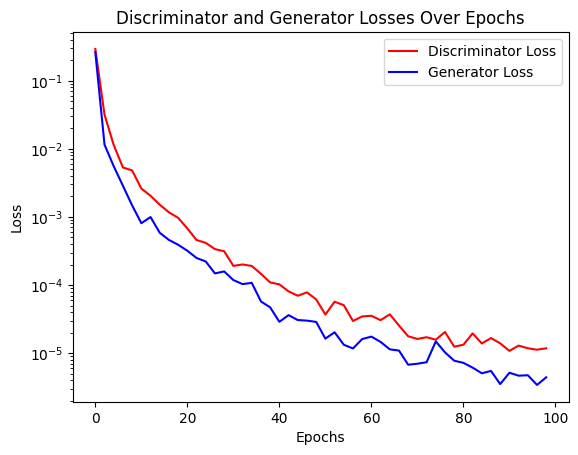

In [65]:
import matplotlib.pyplot as plt
epochs = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98]

import numpy as np
# D Loss values
d_loss = np.array([
    0.2920251786708832, 0.03161967918276787, 0.011338106356561184,
    0.005308095365762711, 0.004808263387531042, 0.0026066747959703207,
    0.0020404639653861523, 0.0015092107933014631, 0.0011652172543108463,
    0.0009689380531199276, 0.0006757030496373773, 0.0004580605309456587,
    0.00041552470065653324, 0.00033641277696006, 0.00031304301228374243,
    0.0001909250277094543, 0.00020026907441206276, 0.0001904071104945615,
    0.0001459774939576164, 0.00010897631000261754, 0.0001023140866891481,
    8.055778744164854e-05, 6.957093864912167e-05, 7.795784767949954e-05,
    6.160305201774463e-05, 3.685287811094895e-05, 5.681292896042578e-05,
    5.058090027887374e-05, 2.9633472877321765e-05, 3.456480772001669e-05,
    3.535534051479772e-05, 3.042946264031343e-05, 3.713547994266264e-05,
    2.5414185074623674e-05, 1.7674185073701665e-05, 1.6161360690603033e-05,
    1.7115609807660803e-05, 1.5747784345876426e-05, 2.0457700884435326e-05,
    1.2434987183951307e-05, 1.3282451618579216e-05, 1.9501216229400598e-05,
    1.385666382702766e-05, 1.664140472712461e-05, 1.3910213056078646e-05,
    1.0794241461553611e-05, 1.2906237316201441e-05, 1.1779691703850403e-05,
    1.1243426342844032e-05, 1.1778650332416873e-05
])

g_loss = np.array([
    0.261537104845047, 0.011480811983346939, 0.0055380892008543015,
    0.0028597088530659676, 0.001475492026656866, 0.0008079035906121135,
    0.0009942954638972878, 0.0005840265075676143, 0.00045898609096184373,
    0.0003898304421454668, 0.0003184705856256187, 0.000249086762778461,
    0.0002215020649600774, 0.0001480580394854769, 0.0001581714313942939,
    0.00011821807129308581, 0.00010311401274520904, 0.00010746873886091635,
    5.7362743973499164e-05, 4.696515679825097e-05, 2.8831967938458547e-05,
    3.6129124055150896e-05, 3.059186929021962e-05, 3.000184369739145e-05,
    2.8734344596159644e-05, 1.632794737815857e-05, 2.0252475223969668e-05,
    1.3276258869154844e-05, 1.1707261364790611e-05, 1.6095247701741755e-05,
    1.7478634617873468e-05, 1.4613614439440425e-05, 1.1372459084668662e-05,
    1.0899967492150608e-05, 6.756370112270815e-06, 6.989296252868371e-06,
    7.354300123552093e-06, 1.4875422493787482e-05, 1.0269224731018767e-05,
    7.741796252958011e-06, 7.202092092484236e-06, 6.12793382970267e-06,
    5.0603912313818e-06, 5.477448212332092e-06, 3.512198190946947e-06,
    5.1513061407604255e-06, 4.66870278614806e-06, 4.737097697216086e-06,
    3.415294486330822e-06, 4.4192097448103596e-06
])
#

# Checking the length of d_loss and g_loss
print(len(d_loss), len(g_loss))
plt.plot(epochs, d_loss, label='Discriminator Loss', color='red')
plt.plot(epochs, g_loss, label='Generator Loss', color='blue')
plt.yscale('log')
plt.title('Discriminator and Generator Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Now you can use the arrays dloss and gloss for further analysis or visualization.


In [68]:
# Save the GAN model
from tensorflow.keras.models import Sequential, save_model
model_path = 'gan_model.h5'
save_model(gan_pitch, model_path)

# Optionally, save the generator and discriminator separately
generator_path = 'generator_model.h5'
save_model(generator_pitch, generator_path)

discriminator_path = 'discriminator_model.h5'
save_model(discriminator_pitch, discriminator_path)

/tmp/ipykernel_47/2997730346.py:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(gan_pitch, model_path)
/tmp/ipykernel_47/2997730346.py:8: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(generator_pitch, generator_path)
/tmp/ipykernel_47/2997730346.py:11: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(discriminator_pitch, discriminator_path)
